# TP : Entraînez-vous à entraîner un algorithme de Machine Learning !

## 1. Preprocess 

To begin with this problem, we will remove outliers (appartement costing more than 10 000€ / month), and we will remove appartement with missing value. 

In [1]:
data_path = "~/Documents/openclassroom/Fomation_ingenieur_ML/data/"

# On importe les librairies dont on aura besoin pour ce tp
import numpy as np
import pandas as pd
## plot : 
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [15, 5]
## stat / model : 
from sklearn.model_selection import train_test_split


In [2]:
### EXTRACTION DATA ###
# On charge le dataset
house_data = pd.read_csv(data_path+'house_data_complete.csv')
print(house_data.head(2),"\n")

# OUTLIERS
print("Before removing outliers, there are ", house_data.shape[0], "considered appartements")
house_data = house_data[house_data['price'] < 10000]
# plt.plot(house_data['surface'], house_data['price'], 'ro', markersize=4)
# plt.show()

## REMOVING NaNs :
print("Before removing uncomplete data (NaNs), there are ", house_data.shape[0], "considered appartements")

#house_data.dropna(axis=0, how = any) 
house_data.dropna(inplace=True) 


print("After preprocessing, there are", house_data.shape[0], "considered appartements")


   price  surface  arrondissement
0   1820     46.1             1.0
1   1750     41.0             1.0 

Before removing outliers, there are  827 considered appartements
Before removing uncomplete data (NaNs), there are  818 considered appartements
After preprocessing, there are 813 considered appartements


## 2. Naive approache and first model : 

### 2.1 Construction of X matrix : 

To train our linear regression, we will need to create the $X$ matrix as : 

$$ X = \begin{pmatrix}
1 & loyer & arr_1(1) & arr_2(1) & \dots & arr_12(1)\\
& & &\dots & &  \\
1 & loyer & arr_1(i) & arr_2(i) & \dots & arr_12(i) \\
& & & \dots & &\\
1 & loyer & arr_1(n) & arr_2(n) & \dots & arr_12(n) 
\end{pmatrix} 
$$

Where 
* k = 1 ... K are the arrondissements
* i = 1 ... n are the appartements
* arr_k(i) is a boolean variable and equals to 1 if the $i^{th}$ appartement is the $k^{th}$ arrondissement, 0 otherwise. 

Indeed, the arrondissement information is a categorial info and not a numerical one. In a first approche, we will consider the arrondissement and surface without putting a weight (see after) 

So, we first need to construct the 0-1 submatrice size $k \times n$, denoted A, containing the information about arrondissement. We will first construct it with a loop and then we will use a pandas.Dataframe method to do it more properly :

In [3]:
## BY HAND METHOD : 
K = np.int(max(house_data["arrondissement"]))
n = house_data.shape[0]
A = np.zeros((n,K))

for k in range(K): 
    A[house_data["arrondissement"]==k,k]=1

TODO test unitaire : vérifier que sum(sum(A))==n

In [4]:
## WITH PANDAS METHOD : 
A = pd.get_dummies(house_data["arrondissement"],prefix="arr")

Concatenate a 1 vector, $A$ and "surface" column of data_house to get $X$

In [5]:
X = np.concatenate((np.matrix([np.ones(house_data.shape[0]), house_data['surface'].values]),A.T)).T
y = np.matrix(house_data['price']).T

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)


### 2.2 Linear Regression : 

After slipping the train and test sets, I choosed the sklearn method "sklearn.linear_model.LinearRegression" and train it on data :

In [6]:
## DEFINE MODEL :
from sklearn import linear_model
regr = linear_model.LinearRegression()

## TRAINING : 
regr.fit(X_train, y_train)

LinearRegression()

In [7]:
tmp = np.concatenate((y_test.T, regr.predict(X_test).T)).T
print( pd.DataFrame(tmp,columns=["value","pred"]).head(5) )

    value         pred
0  1450.0  1374.773217
1  1750.0  2114.322569
2  1900.0  1602.326864
3  1375.0  1739.833253
4   938.0   905.730613


## 3. Introducing the importance of each variable : 

Even thought the results doesn't seem that bad, I am not happy with this modelisation : I did not control how the arrondissement is important compared to the surface of the appartement. To do it, let's introduce an hyperparemeter $\mu$ that enable me to controle the weight/importance of the categorial and numerical variable. The idea is to set the better (in term of training) $\mu$ such that
<center>price = $\mu$ * surface + (1-$\mu$) * $\mathbb{1}_{\text{arrondissement}}$  <\center>
    
Note that this code is not optimized at all, but I gave some semantic variables to easy the lecture. 

In [8]:
## CATEGORICAL VARIABLE MATRIX : 
A = pd.get_dummies(house_data["arrondissement"],prefix="arr")

## MODEL MATRIX WITH HYPERPARAMETER MU : 
y = np.matrix(house_data['price']).T
# semantic variables :
surface = house_data['surface'].values
shift = np.ones(house_data.shape[0])
arrondissement = A.T
      
mu = 0.5                
X_mu = np.concatenate((np.matrix([shift, mu*surface]) , (1-mu)*arrondissement)).T
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)


The issue with this choise is that the train/test sets depend on mu, and it is not our aim. So I think it is a better practice to split the data independantly of mu and modify it after the X_train and X_test. That's what I do now : 

In [9]:
## CATEGORICAL VARIABLE MATRIX : 
A = pd.get_dummies(house_data["arrondissement"],prefix="arr")

## MODEL MATRIX WITH HYPERPARAMETER MU : 
y = np.matrix(house_data['price']).T
# semantic variables :
surface = house_data['surface'].values
shift = np.ones(house_data.shape[0])
arrondissement = A.T
               
X = np.concatenate((np.matrix([shift, surface]) , arrondissement)).T
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [10]:
def mu_weigth_on_X(VarX,Varmu):
    res = VarX.copy()
    res[:,1] = Varmu*res[:,1]
    res[:,2:] = (1-Varmu)*res[:,2:]
    return(res)

mu = 0.5
X_train_mu = mu_weigth_on_X(X_train,mu)
## TRAINING 
regr = linear_model.LinearRegression() 
regr.fit(X_train_mu, y_train)


LinearRegression()

So, we can loop on different vaues of mu to set the better model. The differents methods to split the dataset are presented after (Leave One Out, KFold, Cross Validation). I used the sklearn CV routine : 

In [11]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(regr, X_train_mu, y_train, cv=10)
print(cv_results['test_score'].mean())

0.8431654595220529


In [12]:
mu_values = np.arange(0,0.01,1/10000)
reg_scores = []
for mu in mu_values : 
    X_train_mu = mu_weigth_on_X(X_train,mu)
#     print(X_train_mu[:3,])
    ## LINEAR REGRESSION :
    regr = linear_model.LinearRegression() 
    #regr.fit(X_train_mu, y_train)
    cv_results = cross_validate(regr, X_train_mu, y_train, cv=10)
    
    reg_scores.append(cv_results['test_score'].mean())

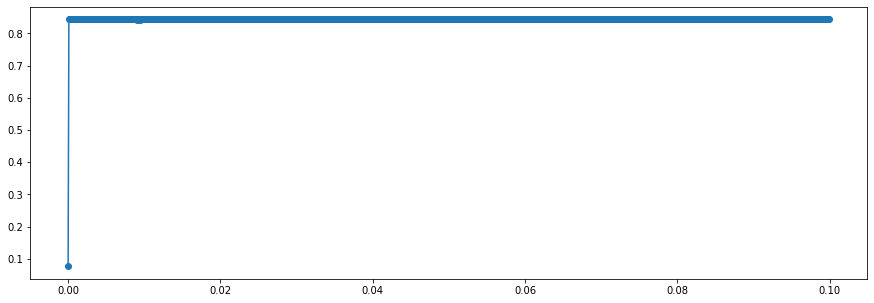

In [13]:
plt.plot(mu_values,reg_scores,'-o')

In [19]:
X_train_mu[:3,]

matrix([[1.      , 5.6943  , 0.      , 0.9001  , 0.      , 0.      ,
         0.      ],
        [1.      , 3.307689, 0.9001  , 0.      , 0.      , 0.      ,
         0.      ],
        [1.      , 2.3976  , 0.9001  , 0.      , 0.      , 0.      ,
         0.      ]])

In [20]:
X_train[:3,]

matrix([[ 1.  , 57.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ],
        [ 1.  , 33.11,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ],
        [ 1.  , 24.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ]])